# Packages:

In [4]:
## Packages:
import time
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, sum, when
from pyspark.sql.functions import count_distinct
from pyspark.sql.functions import create_map, lit
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import math



# PHASE I 
# (0) Data Preparation & EDA in Spark
*   0. Start the spark session 
*   1. Import the data
*   2. Print the Schema

In [5]:
# 0: start the session:
spark = SparkSession.builder.appName("Phase1_EDA").getOrCreate()
print("0. Spark Session started successfully!")

# 1: Import the data set : .csv file
customer_reservation = spark.read.csv("/workspace/CS236_Project_Fall2025_Datasets/customer-reservations.csv",
                                      header=True, inferSchema=True)
hotel_booking = spark.read.csv("/workspace/CS236_Project_Fall2025_Datasets/hotel-booking.csv",
                               header=True, inferSchema=True)

# 2. Print Schema of the dataframes:
print("customer_reservation Schema ") 
customer_reservation.printSchema()
print(f"hotel_booking Schema ")
hotel_booking.printSchema()

0. Spark Session started successfully!
customer_reservation Schema 
root
 |-- Booking_ID: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- booking_status: string (nullable = true)

hotel_booking Schema 
root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (

# (1) Exploratory Data Analysis:
* 3. Number of columns and Rows and Sample Rows
*       FOR EACH DATASET ---
* 4. Missing Values and Null Values 
* 5. Distinct Counts in each Column
* 6. Numerical and Categorical Column List and Analysis
*           a. Summary Statistics of Numerical Columns
*           b. Histograms to show the distribution of Numerical Columns
*           c. Barplot of categorical column "market_segment_type" 

In [6]:
# 3. Number of columns and Rows AND sample Rows:
print(f"customer_resrvation dataframe: \n Number of rows = {customer_reservation.count()}, Number ofcolumns = {len(customer_reservation.columns)}")
customer_reservation.show(2)
print("___________________________________________________________________________")
print(f"hotel_booking dataframe: \n Number of rows = {hotel_booking.count()}, Number ofcolumns = {len(hotel_booking.columns)}")
hotel_booking.show(2)
print("__________________________________________________________________________")





customer_resrvation dataframe: 
 Number of rows = 36275, Number ofcolumns = 10
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+
|Booking_ID|stays_in_weekend_nights|stays_in_week_nights|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|avg_price_per_room|booking_status|
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+
|  INN00001|                      1|                   2|      224|        2017|           10|           2|            Offline|              65.0|  Not_Canceled|
|  INN00002|                      2|                   3|        5|        2018|           11|           6|             Online|            106.68|  Not_Canceled|
+----------+-----------------------+--------------------+---------+------------+-------------+------------+----

### (A) Customer_reservation dataframe:

In [7]:
# 4. Missing values and Null Values:
# Create a report of null counts for each column:
print("4.A:Null Counts Table")
null_counts = customer_reservation.select([sum(col(c).isNull().cast("int")).alias(c) for c in customer_reservation.columns])
null_counts.show()
# Create a report of missing counts for each column:
print("4.B:Missing Values Count Table")
missing_counts_df = customer_reservation.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in customer_reservation.columns]
)
missing_counts_df.show()


# 5. Distinct counts in each column:
print(" 5.Distinct Values per column:")
distinct_counts = customer_reservation.agg(*(count_distinct(c).alias(c) for c in customer_reservation.columns))
distinct_counts.show()
COL=customer_reservation.columns
print(f"number of columns={len(COL)}"); i=1;
print(f"Distinct values in--> '{COL[i]}'")
customer_reservation.select(COL[i]).distinct().show()




4.A:Null Counts Table
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+
|Booking_ID|stays_in_weekend_nights|stays_in_week_nights|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|avg_price_per_room|booking_status|
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+
|         0|                      0|                   0|        0|           0|            0|           0|                  0|                 0|             0|
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+

4.B:Missing Values Count Table
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+---------

6. Summary Statistics for Numerical columns
+-------+-----------------------+
|summary|stays_in_weekend_nights|
+-------+-----------------------+
|  count|                  36275|
|   mean|      0.810723638869745|
| stddev|      0.870643614759999|
|    min|                      0|
|    max|                      7|
+-------+-----------------------+

+-------+--------------------+
|summary|stays_in_week_nights|
+-------+--------------------+
|  count|               36275|
|   mean|  2.2043004824259134|
| stddev|  1.4109048548240162|
|    min|                   0|
|    max|                  17|
+-------+--------------------+

+-------+-----------------+
|summary|        lead_time|
+-------+-----------------+
|  count|            36275|
|   mean|85.23255685733976|
| stddev|85.93081669923292|
|    min|                0|
|    max|              443|
+-------+-----------------+

+-------+------------------+
|summary|      arrival_year|
+-------+------------------+
|  count|             36275|


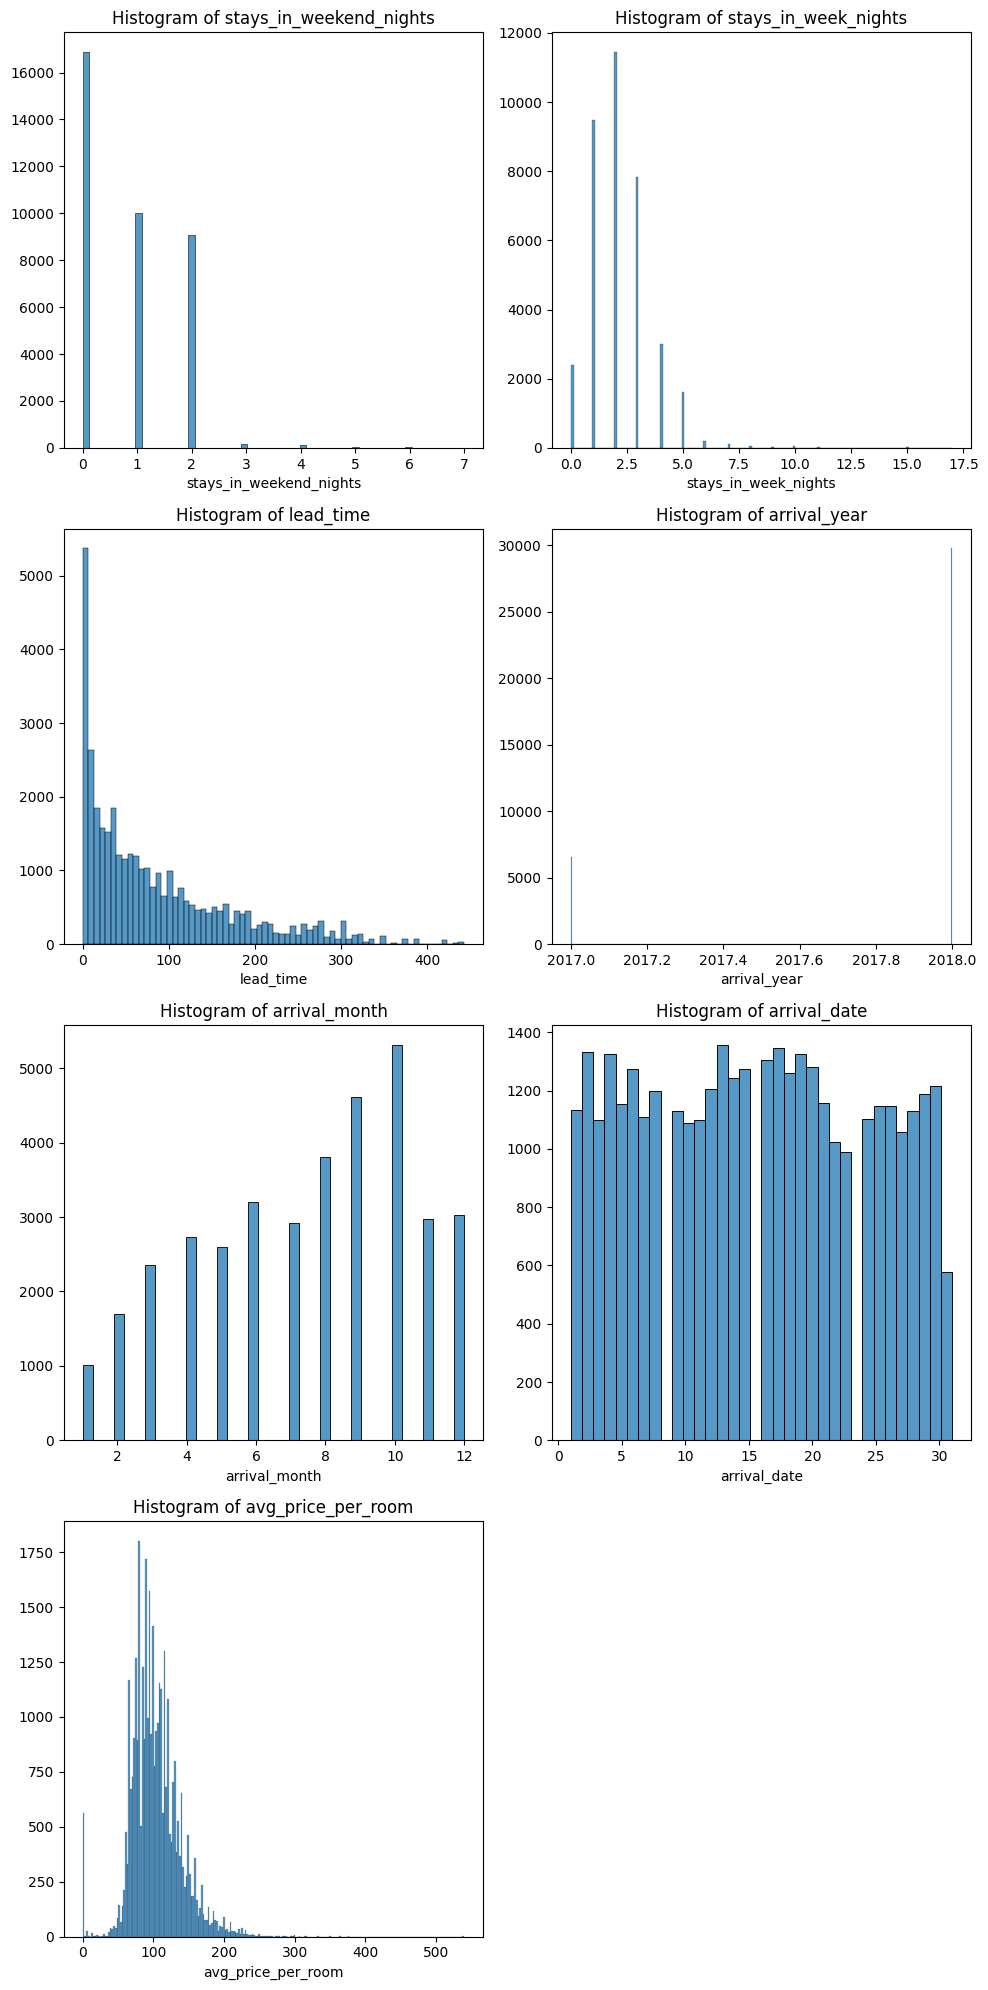

In [8]:
# 6. (A) Numerical and Categorical column lists and analysis:
Num_COL_CR=['stays_in_weekend_nights', 
          'stays_in_week_nights', 'lead_time', 
          'arrival_year', 'arrival_month',
            'arrival_date',  'avg_price_per_room']
Cat_COL_CR=['Booking_ID',  'market_segment_type','booking_status']


# (B) Summary statistics of Numerical columns:
print("6. Summary Statistics for Numerical columns")
for i in range(len(Num_COL_CR)):
    temp_col= customer_reservation.select(col(Num_COL_CR[i]))
    temp_col.describe().show()


df_CR=customer_reservation.toPandas() ## dataframe in Pandas to do the visualization

# (C) Histogram plots to show the distribution of Numerical columns:
df_Num_CR = df_CR[Num_COL_CR]
# Subplot grid: 3 subplots per row
n_plots_per_row = 2
n_col = len(Num_COL_CR) 
#n_rows = (n_col + 1) // 3
n_rows = math.ceil(n_col / n_plots_per_row)


fig, axes = plt.subplots(n_rows, n_plots_per_row, figsize=(10, n_rows * 5)) 
axes = axes.flatten() 

# Loop through each numerical column and create a box plot
for i, col_name in enumerate(Num_COL_CR):
    sns.histplot(x=df_Num_CR[col_name], ax=axes[i])
    axes[i].set_title(f'Histogram of {col_name}')
    axes[i].set_ylabel('')

# Remove any unused subplots if the number of plots is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
#fig.suptitle("Histogram FOR ALL NUMERICAL COLUMNS: customer_reservation.csv",fontsize=10,fontweight='bold') 
plt.tight_layout()
plt.show()



['Booking_ID', 'market_segment_type', 'booking_status']
market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64


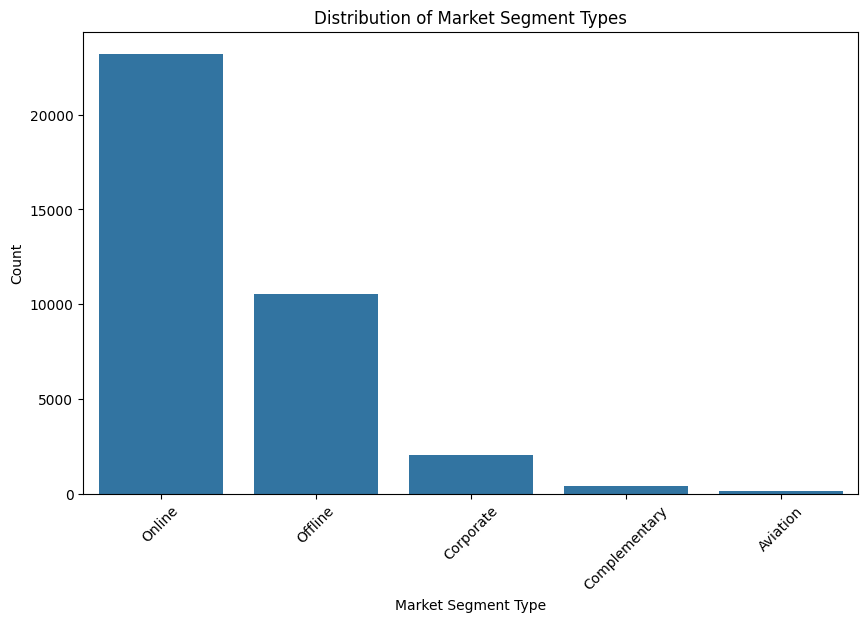

In [9]:
# (D) : Categorical column:
print(Cat_COL_CR)
Cat_df_CR=df_CR[Cat_COL_CR]
# Bar plot for some categorical columns:
new_df= Cat_df_CR['market_segment_type'].value_counts()
print(new_df)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_df.index, y=new_df.values)

# Add titles and labels:
plt.title('Distribution of Market Segment Types')
plt.xlabel('Market Segment Type')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()


### (B) Hotel_Booking Dataframe:


In [10]:
# 4. Missing values and Null Values:
# Create a report of null counts for each column:
print("4. A: Null Counts Table")
null_counts_HB = hotel_booking.select([sum(col(c).isNull().cast("int")).alias(c) for c in hotel_booking.columns])
null_counts_HB.show()

# Create a report of missing counts for each column:
print(" 4.B:Missing Values Count Table")
missing_counts_df = hotel_booking.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in hotel_booking.columns]
)
missing_counts_df.show()


# 5. Distinct counts in each column:
print(" 5.Distinct Values per column:")
distinct_counts = hotel_booking.agg(*(count_distinct(c).alias(c) for c in hotel_booking.columns))
distinct_counts.show()
COL=hotel_booking.columns
print(f"number of columns={len(COL)}"); i=1;
print(f"Distinct values in--> '{COL[i]}'")
hotel_booking.select(COL[i]).distinct().show()


4. A: Null Counts Table
+-----+--------------+---------+------------+-------------+------------------------+-------------------------+-----------------------+--------------------+-------------------+-------+------------------+-----+
|hotel|booking_status|lead_time|arrival_year|arrival_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|market_segment_type|country|avg_price_per_room|email|
+-----+--------------+---------+------------+-------------+------------------------+-------------------------+-----------------------+--------------------+-------------------+-------+------------------+-----+
|    0|             0|        0|           0|            0|                       0|                        0|                      0|                   0|                  0|    405|                 0|    0|
+-----+--------------+---------+------------+-------------+------------------------+-------------------------+-----------------------+------

6. Summary Statistics for Numerical columns
+-------+------------------+
|summary|         lead_time|
+-------+------------------+
|  count|             78703|
|   mean|101.29846384508849|
| stddev|106.20064931641437|
|    min|                 0|
|    max|               737|
+-------+------------------+

+-------+------------------+
|summary|      arrival_year|
+-------+------------------+
|  count|             78703|
|   mean| 2015.720518912875|
| stddev|0.4487471088738672|
|    min|              2015|
|    max|              2016|
+-------+------------------+

+-------+-------------+
|summary|arrival_month|
+-------+-------------+
|  count|        78703|
|   mean|         NULL|
| stddev|         NULL|
|    min|        April|
|    max|    September|
+-------+-------------+

+-------+------------------------+
|summary|arrival_date_week_number|
+-------+------------------------+
|  count|                   78703|
|   mean|      31.577398574387253|
| stddev|      13.332981499918281|
|    

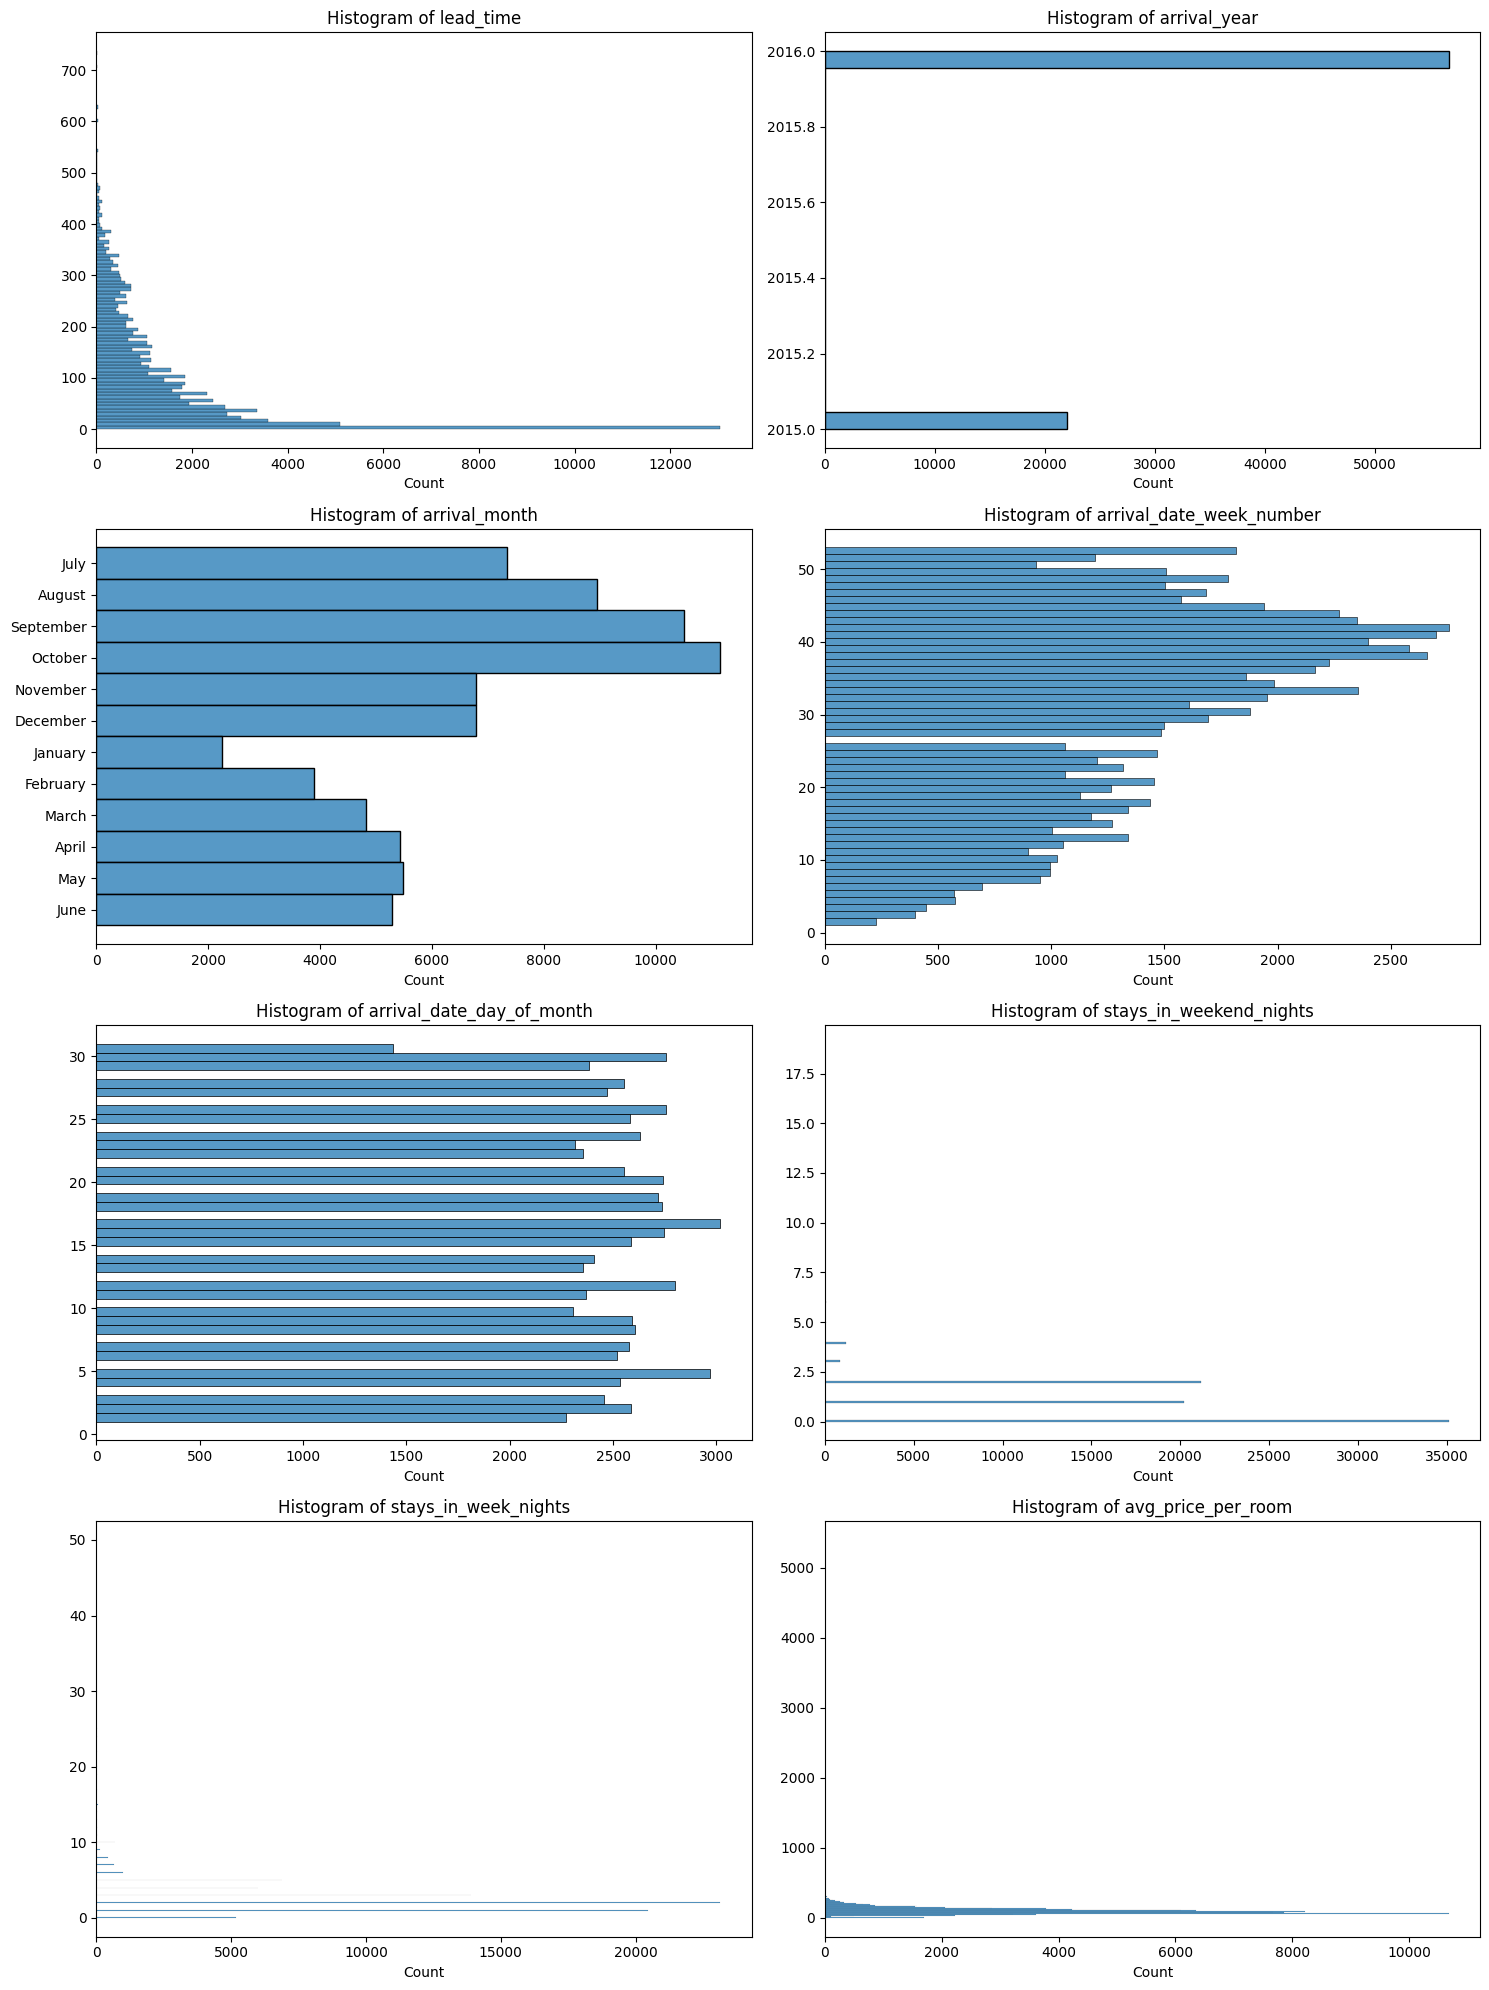

market_segment_type
Online TA        33826
Offline TA/TO    18552
Groups           13957
Direct            7977
Corporate         3733
Complementary      529
Aviation           127
Undefined            2
Name: count, dtype: int64


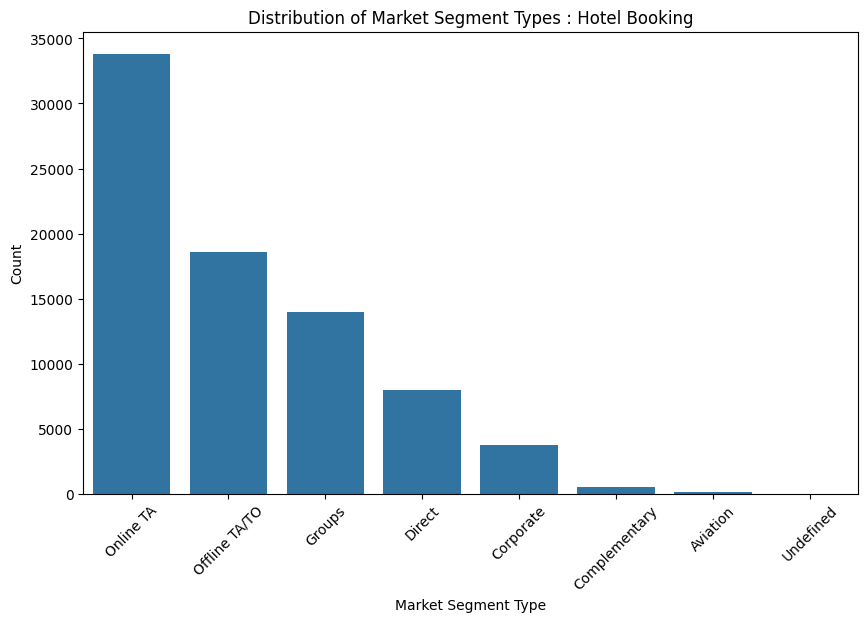

In [11]:
# 6. (A) Numerical and Categorical column lists and analysis:
Num_COL_HB=['lead_time', 'arrival_year', 'arrival_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 
            'stays_in_weekend_nights', 'stays_in_week_nights',  'avg_price_per_room']

Cat_COL_HB=['hotel','booking_status',
            'market_segment_type', 'country', 'email']


# (B) Summary statistics of Numerical columns:
print("6. Summary Statistics for Numerical columns")
for i in range(len(Num_COL_HB)):
    temp_col= hotel_booking.select(col(Num_COL_HB[i]))
    temp_col.describe().show()


df_HB=hotel_booking.toPandas() ## dataframe in Pandas to do the visualization

# (C) Box plots to show the distribution of Numerical columns:
df_Num_HB = df_HB[Num_COL_HB]
# Subplot grid: 3 subplots per row
n_plots_per_row = 2
n_col = len(Num_COL_HB) 
#n_rows = (n_col + 1) // 3
n_rows = math.ceil(n_col / n_plots_per_row)


fig, axes = plt.subplots(n_rows, n_plots_per_row, figsize=(15, n_rows * 5)) 
axes = axes.flatten() 

# Loop through each numerical column and create a box plot
for i, col_name in enumerate(Num_COL_HB):
    sns.histplot(y=df_Num_HB[col_name], ax=axes[i])
    axes[i].set_title(f'Histogram of {col_name}')
    axes[i].set_ylabel('')

# Remove any unused subplots if the number of plots is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
#fig.suptitle("Histogram FOR ALL NUMERICAL COLUMNS: customer_reservation.csv",fontsize=10,fontweight='bold') 
plt.tight_layout()
plt.show()

# (D) : Categorical column:
Cat_df_HB=df_HB[Cat_COL_HB]
# Bar plot for some categorical columns:
new_df= Cat_df_HB['market_segment_type'].value_counts()
print(new_df)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_df.index, y=new_df.values)

# Add titles and labels:
plt.title('Distribution of Market Segment Types : Hotel Booking')
plt.xlabel('Market Segment Type')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

In [12]:
print(f"median={df_Num_HB['avg_price_per_room'].median()}\n,mean={df_Num_HB['avg_price_per_room'].mean()}\n,max={df_Num_HB['avg_price_per_room'].max()}\n,min={df_Num_HB['avg_price_per_room'].min()} \nof avg_price_per room")
#axes[i].set_title(f'Histogram of {col_name}')
#axes[i].set_ylabel('')

median=89.0
,mean=95.21039007407596
,max=5400.0
,min=0.0 
of avg_price_per room


# (2): Data Processing and Creating New Merged_Dataset: CR_HB_df
* 1. Cleaning up the data if needed 
* 2. Compare the Schemas and find the common columns
* 3. Merge the datasets after standardizing the columns
* 4. Save the new Dataset locally


**Observations**
* discrepancies in common columns in both the data sets -
* 'booking_status' : made it unified/standardized via Not_Canceled=1, Canceled=0
* 'arrival_month' : made it standardized via January=1 ... December = 12
* 'market_segment_type' : Offline TA/TO = Offline, Online TA = Online


In [13]:
# Common columns in both data sets -- Analysis for merging:
common_column=list(set(hotel_booking.columns).intersection(set(customer_reservation.columns)))
print(common_column)

for i in range(len(common_column)):
    print('hotel_booking')
    hotel_booking.select(common_column[i]).distinct().show()
    print('customer_reservation')
    customer_reservation.select(common_column[i]).distinct().show()

['stays_in_week_nights', 'arrival_year', 'arrival_month', 'lead_time', 'market_segment_type', 'stays_in_weekend_nights', 'booking_status', 'avg_price_per_room']
hotel_booking
+--------------------+
|stays_in_week_nights|
+--------------------+
|                  34|
|                  12|
|                  22|
|                   1|
|                  13|
|                   6|
|                  16|
|                   3|
|                  20|
|                   5|
|                  19|
|                  15|
|                   9|
|                  17|
|                   4|
|                   8|
|                   7|
|                  10|
|                  50|
|                  25|
+--------------------+
only showing top 20 rows

customer_reservation
+--------------------+
|stays_in_week_nights|
+--------------------+
|                  12|
|                   1|
|                  13|
|                   6|
|                  16|
|                   3|
|                  

In [14]:
# Merge the datasets: along with standardized columns

# Step 1: Standardize the datasets
## standardized booking_status in customer_reservations:
customer_reservation_new = customer_reservation.withColumn(
    "booking_status",
    when(col("booking_status") == "Not_Canceled", 1) #if
    .when(col("booking_status")=="Canceled",0) #elseif
    .otherwise(None) # Else case
)

#customer_reservation.show()
#customer_reservation_new.show()
#customer_reservation_new.select("booking_status").distinct().show()

## standardized month names in hotel_booking:
hotel_booking_new= hotel_booking.withColumn(
    "arrival_month",
    when(col("arrival_month") == "January", 1)
    .when(col("arrival_month") == "February", 2)
    .when(col("arrival_month") == "March", 3)
    .when(col("arrival_month") == "April", 4)
    .when(col("arrival_month") == "May", 5)
    .when(col("arrival_month") == "June", 6)
    .when(col("arrival_month") == "July", 7)
    .when(col("arrival_month") == "August", 8)
    .when(col("arrival_month") == "September", 9)
    .when(col("arrival_month") == "October", 10)
    .when(col("arrival_month") == "November", 11)
    .when(col("arrival_month") == "December", 12)
    .otherwise(None) # else
)
hotel_booking_new =hotel_booking.withColumn(
    "market_segment_type",
    when(col("market_segment_type")=="Offline TA/TO","Offline")
    .when(col("market_segment_type")=="Online TA","Online")
    .otherwise(col("market_segment_type"))
    
)
#hotel_booking_new.show()
#hotel_booking.show()
#hotel_booking_new.select("arrival_month").distinct().show()

# Step 2: MERGE the standardized data sets on the common columns:
#print(f"common column --> {common_column}")
customer_reservation_common=customer_reservation_new.select(common_column)
hotel_booking_common = hotel_booking_new.select(common_column)
#customer_reservation_common.show()
#hotel_booking_common.show()

CR_HB_df = customer_reservation_common.unionByName(hotel_booking_common)
CR_HB_df.printSchema()
CR_HB_df.show()

print(f"CR_HB_df : rows ={CR_HB_df.count()}")


root
 |-- stays_in_week_nights: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)

+--------------------+------------+-------------+---------+-------------------+-----------------------+--------------+------------------+
|stays_in_week_nights|arrival_year|arrival_month|lead_time|market_segment_type|stays_in_weekend_nights|booking_status|avg_price_per_room|
+--------------------+------------+-------------+---------+-------------------+-----------------------+--------------+------------------+
|                   2|        2017|           10|      224|            Offline|                      1|             1|              65.0|
|                   3|        2018|           11|    

In [15]:
# Download and save the new datasets:

# Save as a CSV :
customer_reservation_new.write.mode("overwrite").option("header", "true").csv("/workspace/CS236_Project_Fall2025_Datasets/customer_reservation_new.csv")
hotel_booking_new.write.mode("overwrite").option("header", "true").csv("/workspace/CS236_Project_Fall2025_Datasets/hotel_booking_new.csv")
CR_HB_df.write.mode("overwrite").option("header", "true").csv("/workspace/CS236_Project_Fall2025_Datasets/CR_HB_df.csv")
print("Save as csv successfully!")


Save as csv successfully!


# PHASE II : Spark Analysis and Database population


## (1) Spark Analysis on the unified Data frame:
* Cancellation Rates: for each month
* Compute Average price and Average number of nights for each month
* Monthly bookings : based on market_segment_type
* Seasonality : most popular month on the year based on revenue

In [17]:
# Import the unified dataframe if needed
# via the steps in Phase I -  Step (1)
# Since I am using the same notebook I skipped the step :)

# DATASET for Phase II :
CR_HB_df.printSchema()




root
 |-- stays_in_week_nights: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)

